<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios d'Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Deep Reinforcement Learning


En aquesta pràctica s'implementaran tres models de DRL en un mateix entorn, amb l'objectiu d'analitzar diferents formes d'aprenentatge d'un agent i estudiar-ne el rendiment. L'agent serà entrenat amb els mètodes:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
    <li>REINFORCE with baseline </li>
 </ol>

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i els comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File → Download as → HTML.**

**Cal adjuntar al lliurament els fitxers .pth amb els diferents models entrenats.**

## 0. Contexte

Un dels objectius més actuals del camp de la robòtica és aconseguir que un robot sigui capaç d'aprendre a fer una sèrie d'accions per si sols, de la mateixa manera que ho fa un nen petit. Aquesta és, bàsicament, una de les motivacions principals de l'aprenentatge per reforçament profund. Per això calen sistemes de control eficients en entorns d'alta dimensionalitat com pot ser la inversió en borsa, conducció de cotxes autònoms o, fins i tot, el control de coets espacials. Amb aquesta idea, en aquesta pràctica farem servir un entorn ja predefinit a OpenAI, **Space Invader**.

**Space Invader** consisteix en un canó que pot disparar cap amunt i moure's d'esquerra a dreta. L'objectiu del joc és destruir els extraterrestres enemics, que s'acosten cada cop més ràpid al jugador a mesura que aquest els elimina, i maximitza la puntuació. En aquest entorn, lobservació és una imatge RGB de la pantalla representada per una matriu de forma (210, 160, 3) com s'observa a continuació.

![title](videos/random_agent_space_invader.gif)


Rang d'accions:
* NOOP: 0 (No operació).
* FIRE: 1 (disparar sense moure's)
* RIGHT: 2 (moure a la dreta)
* LEFT: 3 (moure a l'esquerra)
* RIGHTFIRE: 4 (disparar i moure a la dreta)
* LEFTFIRE: 5 (disparar i moure a l'esquerra)

Recompensa: La recompensa tornada per l'entorn està composta per un valor al rang [0, 30]. Depenent de la nau alienígena destruïda, l'agent rep una puntuació diferent.

La nostra tasca és ensenyar-li una política que permeti fer una elecció "bona" per a cada estat.

Per a més detalls sobre la definició de l'entorn Space Invader, es recomana consultar les pàgines web:

<href>https://www.gymlibrary.dev/environments/atari/space_invaders/</href> y  <href>https://atariage.com/manual_html_page.php?SoftwareLabelID=460</href>


## 1. Inicialització i exploració de l'entorn (1 pt)
**IMPORTANT**: l'entorn Space Invader depèn de la instal·lació dels paquets següents
<ul>
      <li>gym[atari] a la versió 0.25.0</li>
      <li>autorom[accept-rom-license]</li>
</ul>

Aquest entorn pot ser executat tant a local com a Kaggle amb la versió de GPU P100 i a Google Colab. Es recomana utilitzar Kaggle per als estudiants que no disposin d'una GPU en local.

Començarem carregant les principals llibreries necessàries per a la pràctica:


In [5]:
#instal·lació de llibreries.
import warnings
warnings.filterwarnings('ignore')
import time
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install imageio
!pip install matplotlib
import gym
import torch
import matplotlib.pyplot as plt
from ale_py import ALEInterface
ale = ALEInterface()
from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
!pip install scikit-image
from skimage import transform
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

In [7]:
# Comprovació de la versió de GYM instal·lada
print('La versió de gym instal·lada: ' + gym.__version__)
# Comprovació d'entorn amb gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("L'entorn utilitza: ", device)

La versió de gym instal·lada: 0.25.0
L'entorn utilitza:  cpu



Comproveu que la cel·la anterior indica que la versió instal·lada del Gym és la 0.25.0.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.1 Exercici (0.2 pts):</strong> Inicialitzar l'entorn SpaceInvaders-v4. Extreure:
<ul>
  <li> Valor del llindar de recompensa definit a l'entorn</li>
  <li> Màxim nombre de passos establerts per a cada episodi</li>
  <li> La dimensió de l'espai d'accions</li>
  <li> La dimensió de l'espai d'observacions.</li>
  </ul>
</div>


In [8]:
warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

####
print("- Rang de recompenses o llindar de les recompenses: {} ".format(env.reward_range))
print("- Màxim nombre de passos per episodi: {} ".format(env.spec.max_episode_steps)) 
print("- Espai d'accions: {} ".format(env.action_space.n))
print("- Espai d'observacions: {} ".format(env.observation_space))


- Rang de recompenses o llindar de les recompenses: (-inf, inf) 
- Màxim nombre de passos per episodi: 100000 
- Espai d'accions: 6 
- Espai d'observacions: Box(0, 255, (210, 160, 3), uint8) 


Com podem veure:
- Encara que el rang a l'enunciat diu que va des de [0,30], l'environtment ens diu que el rang de recompenses o llindar va des de menys infinit fins a més infinit.
- El màxim nombre de passos per episodi és de: 100000
- La dimensió de l'espai d'accions és de 6.
- La dimensió de l'espai d'observacions. Tenim un espai amb forma (210, 160, 3) i els valors que van des del 0 al 255. Per tant, tenim un ordre de magnitud de 256^(210x160x3) = 256^100800. És un conjunt d'estats elevadíssim.

A l'aprenentatge per reforç acostuma a ser molt útil visualitzar el comportament d'un agent al seu entorn. Per a aquesta PAC és interessant poder emmagatzemar el comportament visual d'un agent en forma de fitxer .gif.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.2 Exercici (0.2 pts):</strong>  En aquest exercici us proposem emmagatzemar en una carpeta 'videos' un exemple d'actuació de l'agent aleatori en forma de fitxer .gif.

    -----------------------------------------------------------------------------------------------------------
    
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>


In [4]:
#Mètode per generar la imatge a partir dun estat amb un text informatiu
def _label_with_text(frame):
    '''
    frame: estat de l'entorn GYM.
    '''
    im = Image.fromarray(frame)
    im = im.resize((im.size[0]*2,im.size[1]*2))
    drawer = ImageDraw.Draw(im)
    drawer.text((1, 1), "Uoc Aprenentage Per Reforç.", fill=(255, 255, 255, 128))
    return im

#Mètode que permet crear un gif amb l'evolució d'una partida donat un entorn GYM.
def save_random_agent_gif(env):
    frames = []
    done = False
    env.reset()
    ###########################################   
    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)       
    ##############################################

    env.close()
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_space_invader_usuari.gif'), frames, fps=60)

In [5]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
try:
    os.makedirs('videos')
except:
    pass
save_random_agent_gif(env)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.3 Exercici (0.3 pts):</strong> Executar 1000 episodis amb el màxim de passos establert a l'entorn de Space Invader, prenent accions de forma aleatòria. Emmagatzemeu la suma de recompenses de cada partida i la quantitat d'episodis executats. Mostra:
     <ul>
        <li>Histograma amb la suma de recompenses de cada partida</li>
        <li>Histograma amb la quantitat de passos per resoldre cada partida. </li>
     </ul>
</div>

In [6]:
import warnings
import gym
import sys

warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

def play_games(num_games):    
    steps_list = []
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 2 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        total_reward, steps, done = 0, 0, False
        env.reset()
        while not done:
            env.render(mode='rgb_array')
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            if done:    
                steps_list.append(steps)
                total_reward_list.append(total_reward)
    return steps_list, total_reward_list      
          
steps_list, total_reward_list = play_games(1000)
env.close()   

Episode 998/1000.

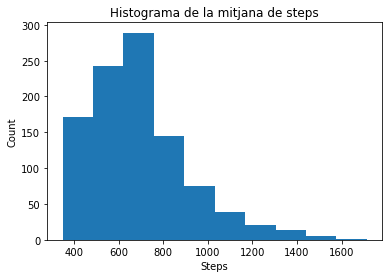

In [7]:
plt.hist(steps_list)
plt.title('Histograma de la mitjana de steps')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.show()

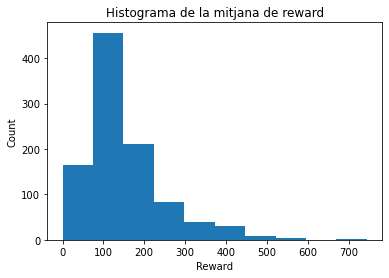

In [8]:
plt.hist(total_reward_list)
plt.title('Histograma de la mitjana de reward')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

In [9]:
print("La mitjana de les passes per episodi és de: {} ".format(np.mean(steps_list)))
print("La mitjana de les recompenses per episodi és de: {} ".format(np.mean(total_reward_list)))

La mitjana de les passes per episodi és de: 683.822 
La mitjana de les recompenses per episodi és de: 149.12 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució:</strong>
<br><br>
La mitjana de passes és del voltant de 688 i una recomenpensa total en cada episodi de quasi 150. Fent servir algoritmes Deep Q-Networks o amb Policy Gradients hauriem d'aconseguir millorar aquests valors de recompensa. 
</div>

## 2. Agent DQN (2.8 pts)
En aquest apartat implementarem una solució DQN per intentar obtenir un model que ens permeti solucionar aquest entorn. Primer definirem el model de xarxa neuronal, després descriurem el comportament de l'agent, l'entrenarem i, finalment, testejarem el funcionament de l'agent entrenat.

### 2.1 Processament de les observacions.


El primer pas és entendre l'estructura de la informació que ens proporciona l'entorn. Els jocs d'Atari utilitzen un espai d'observacions amb una estructura de la forma següent (210, 160, 3), és a dir, 210 píxels d'amplada, 160 d'alçada i 3 colors (RGB). Cadascun d'aquests punts de l'estructura és un píxel de color i té un rang de valors que van des del 0 fins a 255, cosa que ens dóna $256^{(210x160x3)}$ = $256^{100800}$ possibilitats (a mode de comparació, tenim aproximadament $10^{80}$ àtoms a l'univers observable)

<p></p>
<img src="imatges/atomos.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.1 Anàlisi (0.2 pts):</strong> És possible implementar una solució tabular vista durant la PAC1 en aquest entorn de Space Invader? Per què?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta:</strong>
<br><br>
No perquè el nombre d'estats és molt gran i tenim una limitació tant computacional com d’emmagatzematge. Hi ha massa estats i que no es poden representar amb una taula i tampoc no podrem trobar una política o una funció de valor òptimes. 
</div>

En aquest cas, la millor idea és, atès un estat, aproximar els valors Q per a cada possible acció en aquest estat. És a dir, implementarem la solució que pots observar a la figura següent.

<p></p>
<img src="imatges/deep.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<p></p>

Ara bé, al joc Space Invader no tot l'espai té utilitat. El marcador, el marc o la quantitat de vides no és necessari per al desenvolupament del joc. Una pràctica molt habitual en l'aprenentatge per reforç és reduir les dimensions de l'entorn amb l'objectiu de disminuir la quantitat de càlculs necessaris per obtenir un model útil per a l'entorn.

Exactament, per a aquesta PAC us demanarem reduir l'espai dels frames a 84 x 84 píxels, reduir els nostres tres canals de color (RGB) a 1 (blanc i negre), normalitzar el resultat i, finalment, emmagatzemar els 4 últims frames com es mostra a la figura següent:
<p></p>
<img src="imatges/preprocessing.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.2 Exercici (0.1 pts):</strong> Defineix el mètode 'scale_lumininance' per, donat un estat, transformar els punts del sistema RGB al sistema binari blanc i negre.
</div>

In [10]:
def scale_lumininance(obs):
     """
     Separem cada una de les dimensions de RGB    
     Posteriorment calculem el valor del gris en una única dimensió          
     """      
     r, g, b = obs[:,:,0], obs[:,:,1], obs[:,:,2]
     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b 
     return gray.astype(np.uint8)

    # altre implementació
    # return rgb2gray(obs).astype(np.uint8)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.3 Exercici (0.1 pts):</strong> Defineix el mètode 'resize' per, donat un estat, redimensionar la seva mida a 84*84
</div>

In [11]:
def resize(obs):
    """ 
    Resize imatge a 84 * 84
    Fem servir la funció resize del package transform (inclós a skimage)
    """   
    return transform.resize(obs,(84,84))


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.4 Exercici (0.1 pts):</strong> Defineix el mètode 'normalize' per, donat un estat, normalitzar la imatge
</div>

In [12]:
def normalize(obs):
    """ 
    Normalitzem la imatge
    """
    obs /= (obs.max()/255.0)
    return obs.astype(np.uint8)

El resultat que obtindràs serà el següent:
<p></p>
<table  border="0">
<thead>
  <tr style='border:none;' >
    <th style='border:none;' ><img src="imatges/preprocess_grey.png"  width="500"></th>
    <th style='border:none;'><img src="imatges/preprocess_normalize.png"  width="500"></th>
    <th style='border:none;' ><img src="imatges/preprocess_size.png"  width="500"></th>
  </tr>
</thead>
<tbody>
  <tr style='border:none;'>
    <td style='text-align: center; border:none;'> 1.scale_lumininance(obs) </td>
    <td style='text-align: center; border:none;'> 2.resize(obs) </td>
    <td style='text-align: center; border:none;'> 3.normalize(obs)</td>
  </tr>
</tbody>
</table></div>

In [13]:
env.render(mode='rgb_array')
action = env.action_space.sample()
state, reward, done, _ = env.step(action)

# Funció que realitza tot el pre-processament d'una observació
def preprocess_observation(obs):
    obs_proc = scale_lumininance(obs)
    obs_proc = resize(obs_proc)
    obs_proc = normalize(obs_proc)
    return obs_proc

Per últim, com interpretem el moviment? Les imatges corresponen a informació estàtica de les partides i, en aquest entorn, és important conèixer la direcció del tret o el moviment dels invasors. Per això, una forma de gestionar aquesta informació és apilant fotogrames per poder proporcionar a l'algorisme informació sobre la progressió de la partida.


Utilitzem un exemple molt clar, el Ping Pong:
<p></p>
<img src="imatges/temporal-limitation-2.png"  width="1000">

Fixa't com la pilota es desplaça cap a la dreta. L'agrupació dels frames ens permet traslladar la informació espacial al nostre algorisme.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.5 Exercici (0.1 pts):</strong> Implementa la funció stack_frame per apilar 4 frames duna partida. Aquesta funció ha d'apilar inicialment (quan is_new = True) el mateix frame 4 vegades per, posteriorment, conforme es vagin introduint nous frames anar substituint els més antics.
</div>

In [14]:
def stack_frame(stacked_frames, frame, is_new):
        """Stacking Frames.
        Params
        ======
            stacked_frames (array): array de frames (al retornar-lo ha de contenir 4 frames)
            frame: Nova imatge per a afegir a l'array (s'ha d'esborrar la més antiga)
            is_new: Primera vegada que s'utilitza l'array.
        """
        if is_new:
            stacked_frames = np.array([frame, frame, frame, frame])                                    
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame                                
        return stacked_frames

Un cop creada la funció la testegem jugant una partida, emmagatzemant els 4 frames més recents a cada pas, i finalment mostrem els 4 últims frames de la partida.

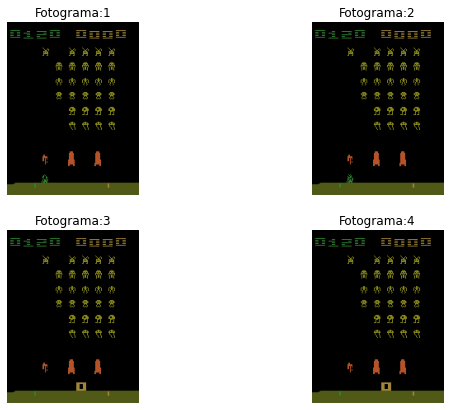

In [15]:
# Omplim 'state_stack' amb 4 còpies idèntiques del frame inicial de la partida
state_stack= stack_frame(None, env.reset(), True)

# Juguem una partida aleatòria i anem actualitzant els 4 frames de 'state_stack'
# conforme es van produint de nous
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    state_stack = stack_frame(state_stack, next_state, False)

    if done:
         break

# Mostrem els darrers 4 frames de la partida que han quedat enmagatzemats a 'state_stack'
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cont=1

for i in state_stack:
    fig.add_subplot(rows, columns, cont)
    plt.imshow(i)
    plt.axis('off')
    plt.title('Fotograma:' + str(cont))
    cont = cont +1

Ara amb aquestes modificacions podem passar al següent punt, la creació de la Xarxa
<p></p>
<img src="imatges/deep-q-network.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

Com s'observa a la imatge, farem servir un model convolucional (perfecte per detectar patrons en imatges) juntament amb un sistema lineal completament connectat. Per a la xarxa convolucional us proposem la següent configuració:

<ul>
    <li>Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.</li>
    <li>Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.</li>
    <li>Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.</li>
</ul>

El resultat d'aquesta primera xarxa (3D) el connectarem amb un model complementament connectat (1D) amb la següent estructura lineal:

* Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU
* Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible).

Finalment, farem servir l'optimitzador Adam per entrenar la xarxa.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.6 Exercici (0.5 pts): </strong>Implementar la classe <code>DQN_CNN()</code>. Inicialitzar les variables necessàries i definir el model CNN i lineal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'acciones possibles
        device: cpu o cuda
        red_cnn: definició de la xarxa convolucional
        red_lineal: definició de la xarxa lineal
        """
        #######################################
        ###TODO: Inicialització i model ###        
        self.learning_rate = learning_rate
        self.input_shape = (4,84,84)
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcció de la xarxa neuronal convolucional
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        if torch.cuda.is_available():
            self.red_cnn.cuda()

        #######################################
        ##TODO: Construcció de la xarxa neuronal lineal completament connectada
        self.fc_layer_inputs = self.feature_size()
        self.red_lineal = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs)
        )


        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        ##TODO: Inicialitzar l'optimitzador
        ## Recupera els paràmetres de la xarxa neuronal i inicialitza l'optimitzador amb el learning rate indicat en el constructor      
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    ### Mètode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:            
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        return self.red_lineal(cnn_out)


    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)

Definim la classe per al *buffer* de repetició d'experiències:

In [17]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Ús de l'operador asterisc per desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.2 Definició de l'agent


A continuació, implementarem una classe que defineixi l'entrenament de l'agent tenint en compte:
     <ul>
         <li>L'exploració/explotació (decaïment d'epsilon)</li>
         <li>L'actualització i sincronització de la xarxa principal i la xarxa objectiu (pèrdua)</li>
     </ul>

A més, considerarem que l'agent ha superat l'entorn quan obtingui una puntuació superior a 350 en 100 partides

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.7 Exercici (1 pt):</strong> Implementar els punts següents de la classe <code>DQNAgent()</code>:
    <ol>
        <li>Declarar les variables de la classe</li>
        <li>Inicialitzar les variables necessàries</li>
        <li>Implementar l'acció que cal prendre</li>
        <li>Actualitzar la xarxa principal segons la freqüència establerta als hiperparàmetres</li>
        <li>Calcular l'equació de Bellman</li>
        <li>Sincronitzar la xarxa objectiu segons la freqüència establerta als hiperparàmetres</li>
        <li>Calcular la mitjana de recompenses dels darrers 100 episodis</li>
        <li>Actualitzar epsilon segons: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
A més, durant el procés s'han d'emmagatzemar (*):
    <ul>
        <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
        <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
        <li>La pèrdua durant l'entrenament</li>
        <li>L'evolució d'epsilon durant l'entrenament</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [18]:
import torch
from copy import deepcopy
import numpy as np
from datetime import datetime

class DQNAgent:
    ###################################################
    ######TODO1: Declarar variables ##################

    def __init__(self, env, main_network,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorn
        main_network: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa
        reward_threshold: llindar de recompensa on es considera que s'ha assolit el problema
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # són els blocs dels X episodis dels quals es calcularà la mitjana de recompensa
        self.reward_threshold = reward_threshold # llindar de recompensa, si es supera es para el procés d'entrenament
        self.initialize()

    ###################################################################
    #####TODO2: Inicialitzar variables extra que són necessàries######
    def initialize(self):
        self.training_update_loss = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        inicio_juego = preprocess_observation(self.env.reset())
        self.state0 = stack_frame(None, inicio_juego, True) # inicialitzem l'stack d'estats amb el valor inicial de la primera observació


    #################################################################################
    ######TODO3: Prendre una nova acció ############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acció aleatòria al burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acció a partir del valor de Q (elecció de l'acció amb millor Q)
            self.step_count += 1

        #TODO: Realització de l'acció i obtenció del nou estat i la recompensa.
        new_state, reward, done, _ = self.env.step(action) 
        new_state = stack_frame(self.state0, preprocess_observation(new_state), False)  # Recordar preprocessar els estats
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiència al buffer
        self.state0 = new_state

        #TODO: Resetejar entorn 'if done'
        if done:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True)
        return done
    
    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        start_time = datetime.now()
        while training:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True)
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')
                #################################################################################
                ####TODO 4: Actualitzar xarxa principal segons la freqüència establerta #########
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                
                ########################################################################################
                ###TODO 6: Sincronitzar xarxa principal i xarxa objectiu segons la freqüència establerta
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())                                        
                                       
                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Emmagatzemar epsilon, training rewards i loss#######
                    self.sync_eps.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)                                                  
                    self.training_update_loss.append(np.mean(self.update_loss))                                         
                    self.update_loss = []

                    #######################################################################################
                    ###TODO 7: Calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    ##################################################################
                    end_time = datetime.now()
                    # get difference time
                    delta = end_time - start_time 
                    # time difference in minutes
                    total_minutes = delta.total_seconds() / 60
                    estimated_remain_time = total_minutes / episode * (max_episodes - episode)                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} Time {} minutes Remaining Time {} minutes\t\t"
                          .format(episode, mean_rewards, round(self.epsilon,4),round(total_minutes,2), round(estimated_remain_time,2)), end="")                    


                    # Comprovar si s'ha arribat al màxim d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    # i s'ha entrenat un mínim d'episodis
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualitzar epsilon ########
                    # actualitzar epsilon segons la velocitat de descens fixada on no pot ser inferior a min_epsilon
                    self.epsilon = max(self.epsilon * self.eps_decay, min_epsilon)


    ####################################
    ####TODO 5: Càlcul de la pèrdua ####
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenim els valors de Q de la xarxa objectiu
        # El paràmetre detach() evita que aquests valors actualitzin la xarxa objectiu
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estats terminals

        #################################################################################
        ###TODO: Calcular l'equació de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch)# calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

### 2.3 Entrenament
A continuació entrenarem el model amb els següents hiperparàmetres:
   <ul>
        <li>Velocitat d'aprenentatge: 0.001 </li>
        <li>Mida del batch: 32</li>
        <li>Capacitat màxima del buffer: 8000</li>
        <li>Gamma: 0.99</li>
        <li>Epsilon: 1, amb decaïment de 0.995 amb un mínim de 0.01</li>
        <li>Nombre d'experiències per emplenar inicialment el buffer: 100</li>
        <li>Nombre màxim d'episodis: 5000</li>
        <li>Nombre mínim d'episodis: 250</li>
        <li>Freqüència d'actualització de la xarxa neuronal: 100 </li>
        <li>Freqüència de sincronització amb la xarxa objectiu: 5000</li>
    </ul>

És probable que amb els hiperparàmetres proposats no s'arribi a solucionar l'entorn (aconseguir una puntuació de 350 a la mitjana de 100 partides). L'objectiu principal és millorar els resultats de l'agent aleatori.

Està permès realitzar modificacions als paràmetres presentats encara que, el darrer exercici d'aquesta PAC, consisteix a millorar els resultats obtinguts amb aquest entrenament. Per tant, encara que sigui permès, no és recomanable.

Si l'alumne no disposa de temps suficient pot escurçar el temps d'entrenament fixant el nombre màxim d'episodis = 3000 en lloc dels 5000 proposats.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.8 Exercici (0.1 pts):</strong> Declarar els hiperparàmetres, carregueu el model de xarxa neuronal i entreneu l'agent
</div>

In [19]:
lr = 0.001          #Velocitat d'aprenentatge
BATCH_SIZE = 32     #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 8000  #Màxima capacitat del buffer
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
EPSILON = 1         #Valor inicial d'epsilon
EPSILON_DECAY = 0.995 #Decaïment d'epsilon
EPSILON_MIN = 0.01  #Valor mínim d'epsilon
BURN_IN = 100       #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 3000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250  #Nombre mínim d'episodis
DNN_UPD = 100       #Freqüència d'actualització de la xarxa neuronal
DNN_SYNC = 5000     #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 350 #Llindar de recompensa on es considera que s'ha assolit el problema

In [20]:
# instanciem la classe del buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# instanciem el model de xarxa neuronal
dqn = DQN_CNN(env, learning_rate=lr)

# instanciem l'agent
agentDQN = DQNAgent(env, dqn, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# entrenem
agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 3000 Mean Rewards 161.05 Epsilon 0.01 Time 155.14 minutes Remaining Time 0.0 minutes					
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.9 Exercici (0.1 pts):</strong> Representar:
    <ol>
        <li>Gràfic amb les recompenses obtingudes al llarg de l'entrenament, l'evolució de les recompenses mitjanes i el llindar de recompensa establert per l'entorn.</li>
        <li>Gràfic amb l'evolució de la pèrdua al llarg de l'entrenament</li>
        <li>Gràfic amb l'evolució d'epsilon durant l'entrenament</li>
    </ol>
</div>

In [21]:
 def plot_rewards(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_rewards, label='Rewards')
        plt.plot(agent.mean_training_rewards, label='Mean Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

 def plot_loss(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_update_loss, label='Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()
        
 def plot_epsilon(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.sync_eps, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.legend(loc="upper left")
        plt.show()
    

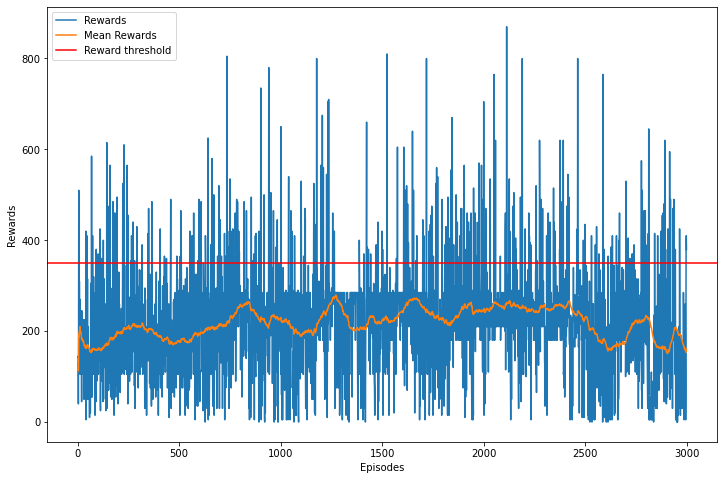

In [22]:
plot_rewards(agentDQN)    

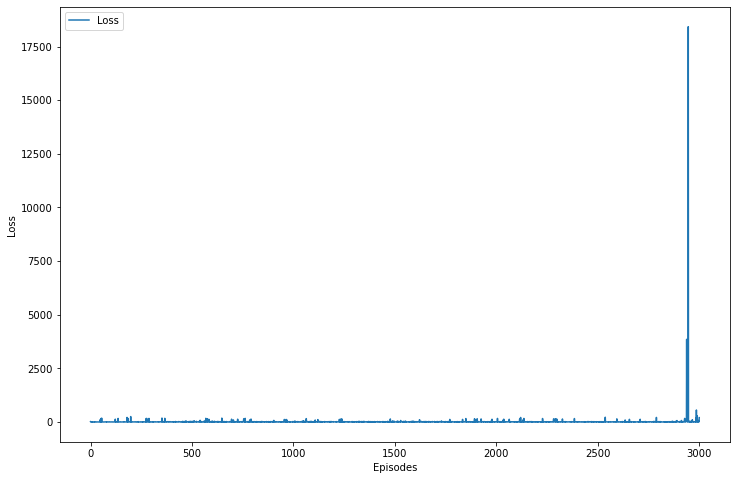

In [23]:
plot_loss(agentDQN)

No es veu gaire cap patró degut a valors extrems que "embruten" la gràfica. Anem a mostrar un altre graf sense aquests valors.

In [24]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def plot_loss_no_outliers(data):
        plt.figure(figsize=(12,8))
        plt.plot(data, label='Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()    

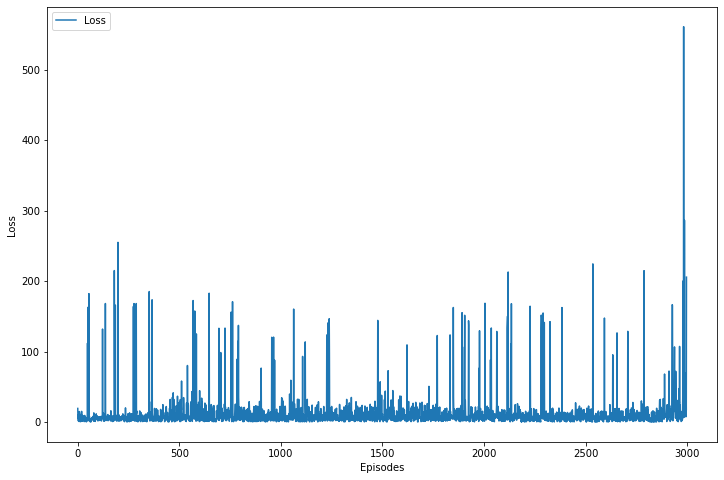

In [25]:
loss_no_outliers = reject_outliers(np.array(agentDQN.training_update_loss))
plot_loss_no_outliers(loss_no_outliers)

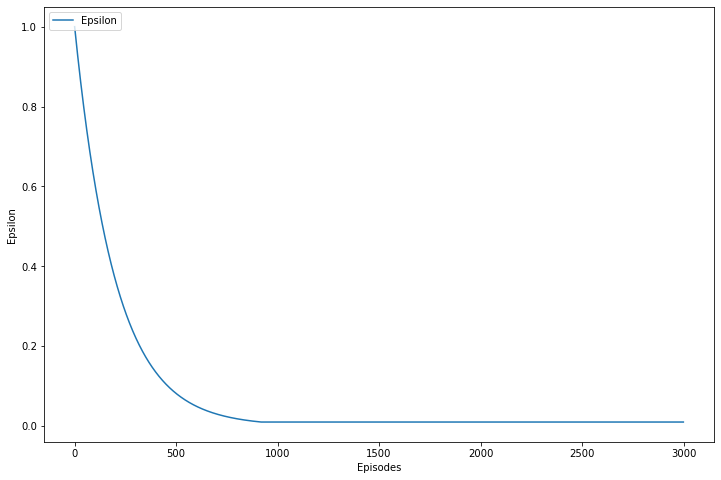

In [26]:
plot_epsilon(agentDQN)

In [27]:
print("La mitjana global de les recompenses és de: {} ".format(np.mean(agentDQN.mean_training_rewards)))

La mitjana global de les recompenses és de: 217.56026977810293 


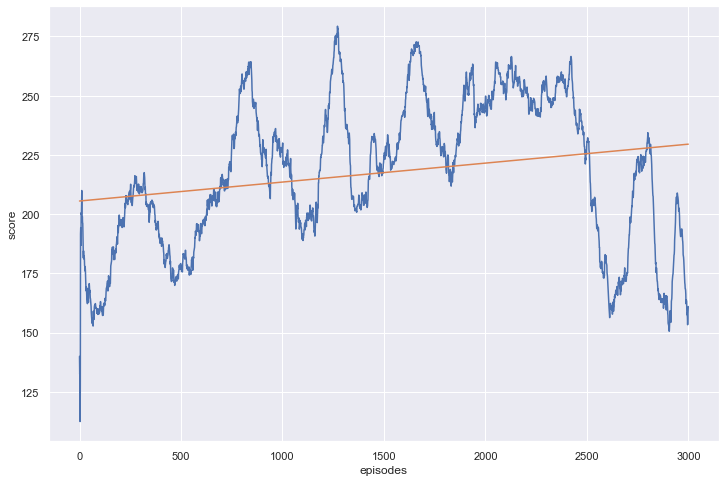

In [28]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set()

scores = agentDQN.mean_training_rewards
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

He volgut mostrar quina seria la tendència amb una regressió lineal de les recompenses de l'aprenentatge i podem veure que no és gens favorable.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.10 Exercici (0.1 pts):</strong> Comenta els resultats
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució:</strong>

Podem observar que en cap moment tenim valors per sobre del threshold. El que si podem dir és que la mitjana de les recompenses està una mica per sobre de l'exercici anterior on teniem només valors aleatoris però és insignificant. A la gràfica de rewards podem observar que tenim molta fluctació en les recompenses. 
    
El gràfic de la pèrdua no sembla que que tingui bona representació ja que és una mesura de quant s'allunya la sortida de la xarxa neuronal del que s'espera que sigui la sortida correcta. Per tant al principi aquest valor hauria de ser més alt i conforme anés entrenant hauria d'anar disminuint fins a estabilitzar-se. He tret valors extrems per veure si podem veure un patró en la pèrdua. 

La epsilon comença al valor màxim i va disminuint conforme es van jugant les partides. Al principi agafa tot accions aleatories amb epsilon quasi amb valor 1. Conforme va disminuint de 1 de forma progrtessiva, cada cop agafa menys aleatories i fa servir el model d'aprenentatge fins que amb el valor mínim de epsilon agafa quasi totes del model.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.11 Exercici (0.1 pts):</strong> Guardar el model entrenat en format ".pth" amb el nom "agentDQN_Trained_Model_dqn_cnn.pth".
</div>

In [29]:
torch.save(agentDQN.main_network.state_dict(), 'agentDQN_Trained_Model_dqn_cnn.pth')

### 2.4 Test de l'agent entrenat

Un cop entrenat l'agent, ens interessa comprovar com ha après de bé, si el "robot" és capaç de realitzar les tasques apreses. Per això, recuperem el model entrenat i deixem que l'agent prengui accions aleatòries segons aquest model i n'observem el comportament.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.12 Exercici (0.2 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calcular la suma de recompenses per a cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
</div>

Episode 19/20.

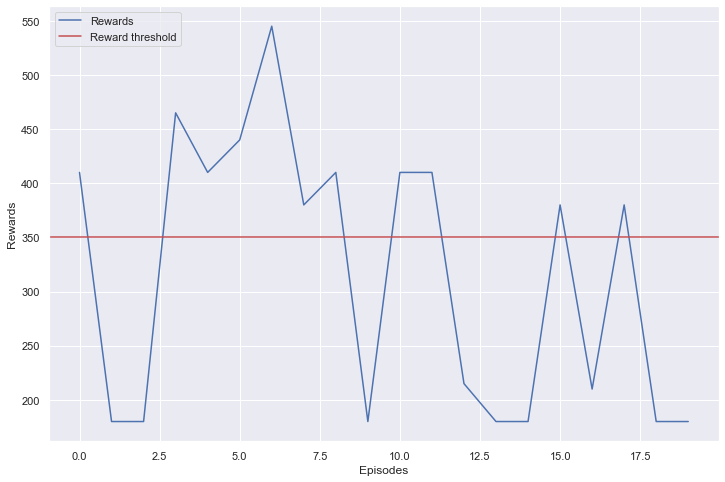

In [30]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        observation = env.reset()
        start_game = preprocess_observation(observation)
        state= stack_frame(None, start_game, True)
        total_reward = 0
        done = False
        while not done:
            action = ag.main_network.get_action(state,epsilon=0.0)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            state= stack_frame(state, preprocess_observation(observation), False)
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          
total_reward_list = play_games(env, agentDQN, 20)


def plot_rewards_min(agent, total_reward_list):
        plt.figure(figsize=(12,8))
        plt.plot(total_reward_list, label='Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

plot_rewards_min(agentDQN, total_reward_list)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.13 Anàlisi (0.1 pts):</strong> Emmagatzema una partida d'exemple de l'agent a la carpeta vídeos en format GIF per poder visualitzar-ne el comportament (es dóna el codi fet) i comenta el comportament de l'agent entrenat.
</div>

In [31]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# Funció per a jugar i enmagatzemar una partida en format GIF amb un agent entrenat
def save_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :param nombre_fichero:  nom del fitxer
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    incio_juego = preprocess_observation(observation)
    state= stack_frame(None, incio_juego, True)
    total_reward = 0 
    t=0
    while True:
            state= stack_frame(state, preprocess_observation(observation), False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))                
            action = ag.main_network.get_action(state,epsilon=0.0)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

# Juguem i enmagatzemem una partida amb l'agent entrenat 
save_agent_gif(env,agentDQN, 'agent_dqn.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta (comentaris):</strong>
<br><br>
L'agent entrenat te un comportament repetitiu i similar al exemple que han facilitat a l'exercici. No es mou de la seva posició fins que finalitza la partida.
<br><br>
    
![title](videos/agent_dqn.gif)    
</div>


Pot ser que el resultat sigui molt semblant al següent GIF. No us preocupeu, amb els paràmetres escollits és difícil obtenir un millor rendiment.
    
![title](videos/space_invader_dqn_comportamiento_continuo.gif)

## 3. Agent Dueling DQN (2.2 pts)

En aquest apartat resoldrem el mateix entorn amb les mateixes característiques per a l'agent, però usant una dueling DQN. Com en el cas anterior, primer definirem el model de xarxa neuronal, després descriurem el comportament de l'agent, l'entrenarem i, finalment, en testejarem el funcionament.

### 3.1 Definició de l'arquitectura de la xarxa neuronal


L'objectiu principal de les dueling DQN és "estalviar-se" el càlcul del valor de Q en aquells estats on és irrellevant l'acció que es prengui. Per això es descompon la funció Q en dos components:


$$Q(s, a) = A(s, a) + V (s)$$


Aquesta descomposició es fa a nivell de l'arquitectura de la xarxa neuronal. Les primeres capes que teníem a la DQN seran comuns, i després la xarxa es dividirà en dues parts separades definides per la resta de capes.

La descomposició en subxarxes del model de la DQN implementada a l'apartat anterior serà llavors:
<ol>
     <li>Bloc comú, la xarxa CNN</li>
     <li>Xarxa advantage A(s,a):</li>
          <ul>
              <li>Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU</li>
              <li>Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, el nombre de neurones de sortida dependrà del tipus de xarxa, A(s,a) en aquest cas, i tindrà tantes neurones com dimensions tingui l'espai d'accions.</li>
              </ul>
     <li>Xarxa value V(s):</li>
             <ul>
              <li>Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU</li>
              <li>Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida amb un valor per estat.</li>
              </ul>
</ol>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.1 Exercici (0.75 pts):</strong> Implementar la classe <code>duelingDQN()</code>. Inicialitzar les variables necessàries i definir el model funcional de xarxa neuronal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

class DuelingDQN(torch.nn.Module):
    ###################################
    ###TODO: inicialització i model ###
    def __init__(self, env, learning_rate=1e-3):
        """
        Params
        ======
        input_shape: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        device: cpu o cuda
        red_cnn: definició de la xarxa convolucional
        value: definició de la xarxa neuronal value
        advantage: definició de la xarxa neuronal advantage
        """
        ###################################
        ###TODO: Inicialitzar variables####
        super(DuelingDQN, self).__init__()
        self.input_shape = (4,84,84)
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        ########################################
        ##TODO: Construcció de la xarxa neuronal
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        if torch.cuda.is_available():
            self.red_cnn.cuda()


        self.fc_layer_inputs = self.feature_size()

        self.advantage = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs)
        )

        self.value = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        ### S'ofereix l'opció de treballar amb cuda
        if self.device == 'cuda':
            self.value.cuda()
            self.advantage.cuda()

        ### Inicialitzem l'optimitzador
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #######################################
    #####TODO: funció forward#############
    def forward(self, x):
        """  
        x: estat de l'entorn
        """   
        if len(x.shape) == 3:
            x = x.unsqueeze(0) # afegim una dimensió per a poder passar-la a la xarxa convolucional en cas que sigui un estat i no un batch d'estats
                                    
        x = self.red_cnn(x) # x: sortida de la xarxa convolucional
        x = x.view(x.size(0), -1) # aplana la xarxa convolucional per a poder passar-la a la xarxa neuronal avantatge i value
        advantage = self.advantage(x) # advantage: sortida de la xarxa neuronal advantage
        value = self.value(x) # value: sortida de la xarxa neuronal value
        return value + advantage - advantage.mean() # sortida de la xarxa neuronal
        

    ### Métode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acció aleatòria
        else:
            qvals = self.get_qvals(state)  # acció a partir del càlcul del valor de Q per a aquesta acció
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)


    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)


Per al buffer de repetició d'experiències podem fer servir exactament la mateixa classe 'experienceReplayBuffer' descrita a l'apartat anterior de la DQN.

### 3.2 Definició de l'agent

La diferència entre la DQN i la dueling DQN se centra, com hem vist, a la definició de l'arquitectura de la xarxa. Però el procés daprenentatge i actualització és exactament el mateix. Així, podem recuperar la classe implementada a l'apartat anterior, DQNAgent() i reutilitzar-la aquí sota el nom de duelingDQNAgent(). L'únic que cal fer és afegir l'optimitzador entre les variables a declarar i adaptar la funció de pèrdua al format Functional de pytorch.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.2 Exercici (0.5 pts):</strong> Implementar la classe <code>duelingDQNAgent()</code> com la <code>DQNAgent()</code>
<p>
</p>
De nou, durant el procés s'han d'emmagatzemar (*):
     <ul>
         <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
         <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
         <li>La pèrdua durant l'entrenament</li>
         <li>L'evolució d'epsilon durant l'entrenament</li>
     </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [33]:
class DuelingDQNAgent:
 ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock = 100):
        """"
        Params
        ======
        env: entorn
        dnnetwork: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        reward_threshold: llindar de recompensa definit a l'entorn
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa        
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.initialize()

    ###############################################################
    ####TODO 2: inicialitzar variables extra que es necessiten ####
    def initialize(self):
        self.total_reward = 0
        self.step_count = 0
        self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True) # inicialitzem l'stack d'estats amb el valor inicial de la primera observació

        self.update_loss = [] # loss de l'actualització de la xarxa
        self.training_update_loss = [] # pérdues de l'entrenament
        self.training_rewards = [] # recompenses de l'entrenament
        self.mean_training_rewards = [] # mitjana de recompenses de l'entrenament
        self.sync_eps = [] # epsilon de sincronització


    #################################################################################
    ######TODO 3: Prendre una nova acció ############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acció aleatòria al burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acció a partir del valor de Q (elecció de lacció amb millor Q)
            self.step_count += 1

        #TODO: Realització de l'acció i l'obtenció del nou estat i la recompensa
        new_state, reward, done, _ = self.env.step(action)                  
        new_state = stack_frame(self.state0, preprocess_observation(new_state), False)

        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiència al buffer
        self.state0 = new_state.copy()
        
        #TODO: resetejar entorn 'if done'
        if done:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True)
        return done

    ## calcula la diferencia entre dos tiempos
    def time_diff(self, start_time, end_time):
        diff = end_time - start_time
        return diff.seconds + diff.microseconds / 1e6

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        start_time = datetime.now()
        while training:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True)
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                #####TODO 4: Actualitzar la xarxa principal segons la freqüència establerta #####
                if self.step_count % dnn_update_frequency == 0:
                     self.update()

                ########################################################################################
                ###TODO 6: Sincronitzar xarxa principal i xarxa objectiu segons la freqüència establerta
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Emmagatzemar epsilon, training rewards i loss#######
                    self.sync_eps.append(self.epsilon) # emmagatzemar epsilon de sincronització per a cada episodi 
                    self.training_rewards.append(self.total_reward) # emmagatzemar recompensa de cada episodi
                    
                    self.training_update_loss.append(np.mean(self.update_loss))                                             
                    self.update_loss = []

                    #######################################################################################
                    ###TODO 7: calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:]) # mitjana de recompenses de l'entrenament dels últims X episodis
                    self.mean_training_rewards.append(mean_rewards) # emmagatzemar mitjana de recompenses de l'entrenament


                    ##################################################################
                    end_time = datetime.now()
                    # get difference time
                    delta = end_time - start_time 
                    # time difference in minutes
                    total_minutes = delta.total_seconds() / 60 # temps total d'entrenament en minuts
                    estimated_remain_time = total_minutes / episode * (max_episodes - episode) # temps estimat que resta per a acabar l'entrenament en minuts               
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} Time {} minutes Remaining Time {} minutes\t\t".format(episode, mean_rewards, self.epsilon,round(total_minutes,2), round(estimated_remain_time,2)), end="")                    


                    # Comprovar si s'ha arribat al màxim d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    # i s'ha entrenat un mínim d'episodis
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualitzar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, min_epsilon) # actualitzar epsilon


     ## Càlcul de la pèrdua
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device=self.device)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        #DQN update#
        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        if self.device == 'cuda':
            next_actions_vals = next_actions.reshape(-1,1).to(device=self.device)
        else:
            next_actions_vals = torch.LongTensor(next_actions).reshape(-1,1).to(device=self.device)
        # Obtenim els valors de Q de la xarxa objectiu
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()
        #####

        qvals_next[dones_t] = 0 # 0 en estats terminals

        #TODO: Calculem l'equació de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        
        # Modifiquem la funció de Loss per al mode Functional######
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
      
        return loss



    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch) # calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Desem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())






### 3.3 Entrenament
A continuació entrenarem el model dueling DQN amb els mateixos hiperparàmetres amb què entrenem la DQN.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.3 Exercici (0.1 pts):</strong> Carregar el model de xarxa neuronal i entrenar l'agent amb els mateixos hiperparàmetres usats per a la DQN
</div>

In [34]:
lr = 0.001          #Velocitat d'aprenentatge
BATCH_SIZE = 32     #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 8000  #Màxima capacitat del buffer
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
EPSILON = 1         #Valor inicial d'epsilon
EPSILON_DECAY = 0.995 #Decaïment d'epsilon
EPSILON_MIN = 0.01  #Valor mínim d'epsilon
BURN_IN = 100       #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 3000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250  #Nombre mínim d'episodis
DNN_UPD = 100       #Freqüència d'actualització de la xarxa neuronal
DNN_SYNC = 5000     #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 350 #Llindar de recompensa on es considera que s'ha assolit el problema

In [35]:
# instanciem la classe del buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# instanciem el model de xarxa neuronal
ddqn = DuelingDQN(env, learning_rate=lr)

# instanciem l'agent
agentDDQN = DuelingDQNAgent(env, ddqn, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# entrenem
agentDDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 3000 Mean Rewards 156.50 Epsilon 0.01 Time 238.76 minutes Remaining Time 0.0 minutes				09.3 minutes			
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.4 Exercici (0.2 ptos):</strong> Mostrar els mateixos gràfics que amb la DQN:
     <ol>
         <li>Recompenses obtingudes al llarg de l'entrenament i l'evolució de les recompenses mitjanes cada 100 episodis, juntament amb el llindar de recompensa establert per l'entorn</li>
         <li>Pèrdua durant l'entrenament</li>
         <li>Evolució d'epsilon durant l'entrenament</li>
     </ol>
</div>

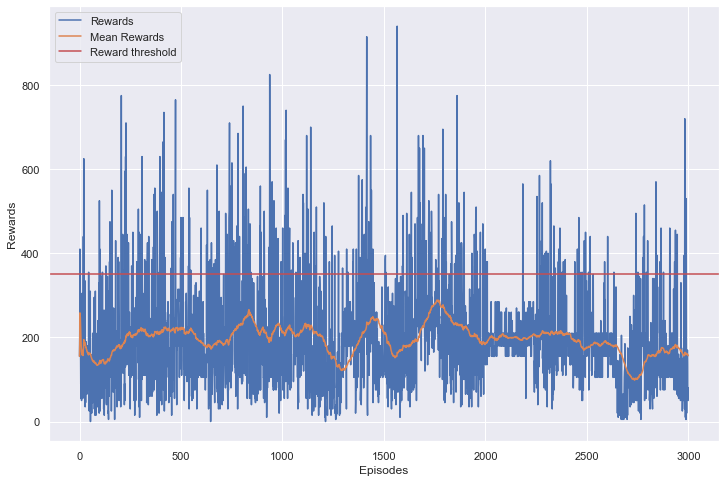

In [36]:
plot_rewards(agentDDQN)

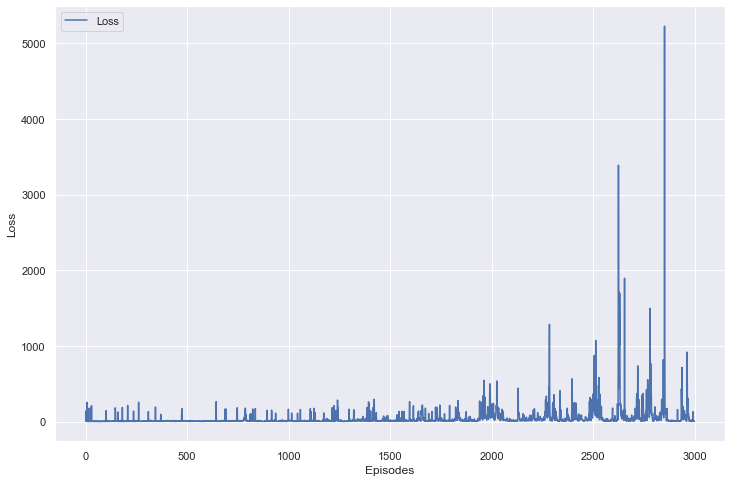

In [37]:
plot_loss(agentDDQN)

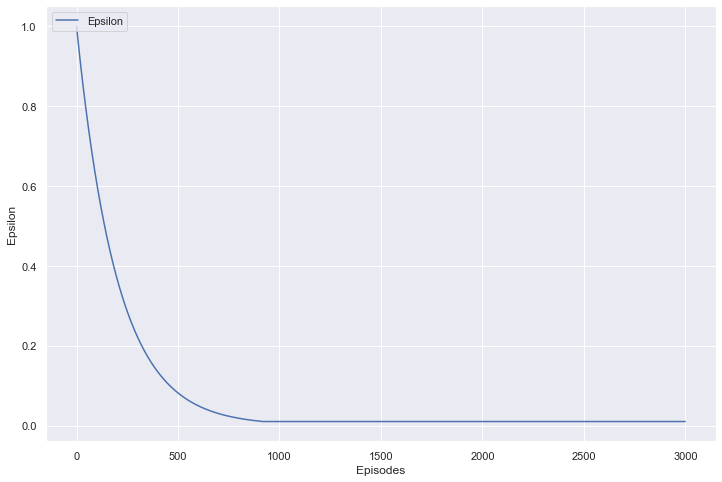

In [38]:
plot_epsilon(agentDDQN)

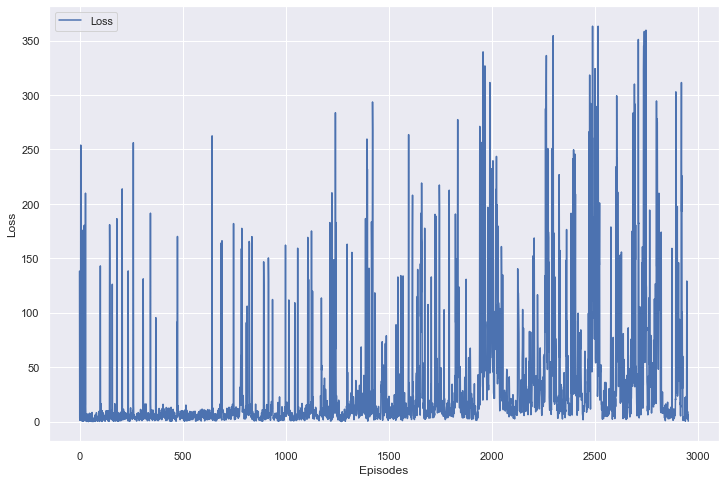

In [39]:
loss_no_outliers = reject_outliers(np.array(agentDDQN.training_update_loss))
plot_loss_no_outliers(loss_no_outliers)

In [40]:
print("La mitjana global de les recompenses és de: {} ".format(np.mean(agentDDQN.mean_training_rewards)))

La mitjana global de les recompenses és de: 195.1028646879141 


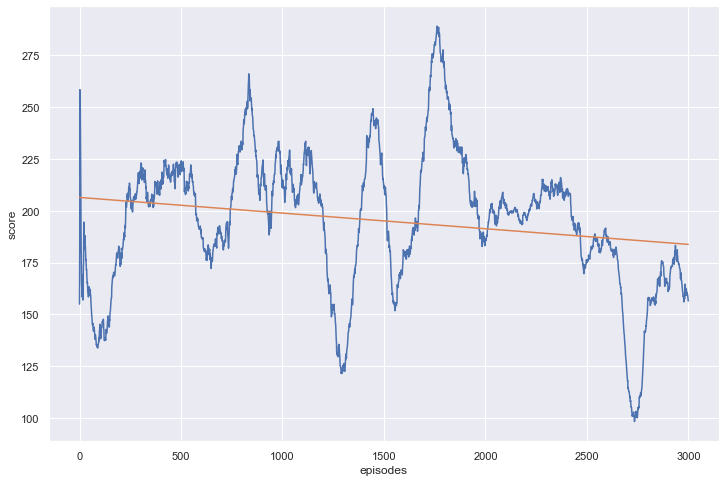

In [41]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set()

scores = agentDDQN.mean_training_rewards
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

En aquest cas podem dir que la progressió de l'aprenentatge de Dueling DQN és prou bó i potser amb més iteracions aconseguiriem la fita establerta.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.5 Exercici (0.1 pts):</strong> Guardar el model entrenat en format “.pth”.
</div>

In [42]:
torch.save(agentDDQN.main_network.state_dict(), 'agentDDQN_Trained_Model_ddqn_cnn.pth')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.6 Anàlisi (0.1 pto):</strong> Comenta els resultats obtinguts
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br><br>
Visualment en els plots de reward veiem que amb Dueling DQN tenim millors resultats en les recompenses mitjanes que amb DQN. Si fem una mitjana global veiem que realment és així ja que estem per sobre dels 220.  
<br><br>
Sembla que el fet de tenir en compte no només el valor de l'estat sino el valor de l'acció millorem la precissió i es veu l'aprenentatge més estable. A la gràfica es veu com els rewards van augmentant de forma més líneal i progressiu.   
<br><br>
De totes formes les epsilon no son prou clares en aquest sentit ja que no mostren el que sembla que haurien de mostrar. Valors més grans a l'inici i haurien de decaure fins a estabilitzar-se. Pot tenir a veure amb el valor de la freqüència d'actualització de la xarxa neuronal, que és molt alt. Amb valors alts no convergeix el model no convergeix. 
<br><br>
</div>

### 3.4 Test de l'agent
Finalment, analitzem el comportament de l'agent entrenat.
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.7 Exercici (0.2 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calculeu la suma de recompenses per cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
</div>

Episode 19/20.

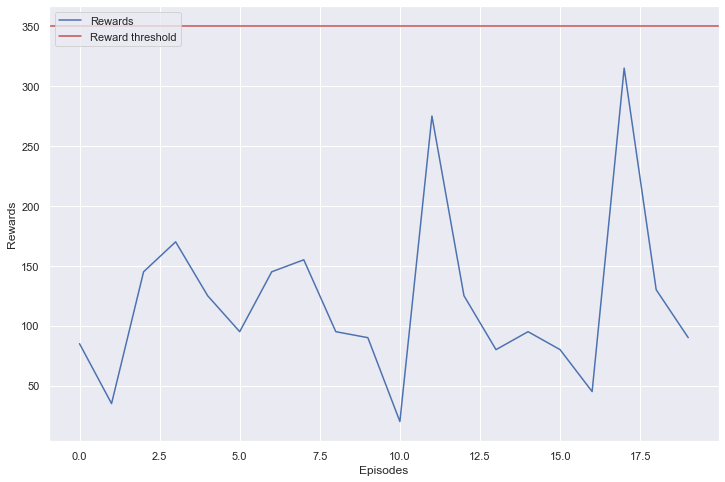

In [43]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')   

total_reward_list = play_games(env, agentDDQN, 20)
plot_rewards_min(agentDDQN, total_reward_list)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.8 Anàlisi (0.25 pts):</strong> Emmagatzema una partida d'exemple de l'agent a la carpeta de vídeos en format GIF per poder visualitzar el seu comportament i comenta el comportament de l'agent entrenat.
</div>

In [44]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# Juguem i enmagatzemem una partida amb l'agent entrenat 
save_agent_gif(env, agentDDQN, 'space_invader_duelingDQNAgent_comportamiento.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta (comentaris):</strong>
<br><br>
En aquest cas tenim un comportament una mica més smart, os veiem al player realitzar moviments en la partida quan els oponents es se li encaren.
<br>    
    
![title](videos/space_invader_duelingDQNAgent_comportamiento.gif)    
</div>

## 4. REINFORCE with baseline (2 pts)

### 4.1 Definició de l'arquitectura de la xarxa neuronal
Utilitzarem un model Seqüencial amb la configuració següent:

<ul>
    <li>Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=(8,64,64), out_channels=32, kernel_size=8, stride=4 amb activació ReLU.</li>
    <li>Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.</li>
    <li>Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.</li>
</ul>

El resultat d´aquesta primera xarxa el connectarem amb un model complementament connectat amb la següent estructura:

* Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, bias=True i amb activació Tanh
* Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible), bias=True i activació Softmax (dim=-1).

Finalment, farem servir l'optimitzador Adam per entrenar la xarxa.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1 (0.5 ptos):</strong> Implementar la classe <code>PGReinforce()</code>. Inicialitzar les variables necessàries i definir el model Seqüencial de xarxa neuronal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [45]:
class PGReinforce(torch.nn.Module):

    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        print("init")
        """
        Params
        ======
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        """
        super(PGReinforce, self).__init__()
         ###################################
        ####TODO: Inicialitzar variables####
        self.input_shape = (4,84,84)
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.device = 'cpu'
        self.learning_rate = learning_rate
        ######

        ########################################

        ##TODO: Construcció de la xarxa neuronal
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        if self.device == 'cuda':
            self.red_cnn.cuda()

        self.fc_layer_inputs = self.feature_size()
        self.red_lineal = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, self.n_outputs, bias=True),
            nn.Softmax(dim=-1)
        )

        ### S'ofereix l'opció de treballar amb cuda
        if self.device == 'cuda':
            self.red_lineal.cuda()


        #######################################
        ##TODO: Inicialitzar l'optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #####

    # Obtenció de les probabilitats de les possibles accions
    def get_action_prob(self, state):
        if type(state) is tuple:
            state = np.array(state)        
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)   
        cnn_lineal_out = self.red_lineal(cnn_out)
        # clipped per evitar NaNs.          
        cnn_lineal_out_clamped = torch.clamp(cnn_lineal_out, 1e-8, 1-1e-8)  
        return cnn_lineal_out_clamped

    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)

La funció torch.clamp() de PyTorch rep els valors del tensor, un valor mínim i un valor màxim. A continuació, substitueix tots els valors del tensor que siguin menors al valor mínim pel valor mínim, i tots els valors del tensor que siguin majors al valor màxim pel valor màxim. D'aquesta manera, es garanteix que tots els valors del tensor estiguin compresos entre 0 i 1. 
Això és útil amb xarxes neuronals basades en probabilitats com la nostre i ens evitem tenir NaN. En el meu cas, quan els valors eran molt petit acababen convertits en NaN i amb aquesta forma evitem el problema.

### 4.2 Definición del agente
<p></p>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.2 Exercici (0.55 pts):</strong> Implementar els punts següents de la classe <code>reinforceAgent()</code>:
<ol>
         <li>Declarar les variables de la classe</li>
         <li>Inicialitzar les variables necessàries</li>
         <li>Implementar l'acció que cal prendre</li>
         <li>Calcular el <i>discounted reward</i> usant com a línia de base la mitjana estandarditzada del retorn
                $$ \frac{x_i - \bar{x}}{\sigma_x}$$</li>
         <li>Calcular la mitjana de recompenses dels últims 100 episodis</li>
         <li>Implementar la pèrdua per actualització</li>
     </ol>
A més, durant el procés s'han d'emmagatzemar (*):
     <ul>
         <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
         <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
         <li>La pèrdua durant l'entrenament</li>
     </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [46]:
class ReinforceAgent:

    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, dnnetwork, nblock=100, reward_threshold=350):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.dnnetwork = dnnetwork
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.initialize()
     #######

    ###############################################################
    ####TODO 2: inicialitzar variables extra que es necessitin ####
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1

        self.training_update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_loss = []       

    ######

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size

        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        start_time = datetime.now()
        print("Training...")
        while training:
            start_game = preprocess_observation(self.env.reset())
            state0 = stack_frame(None, start_game, True)
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False

            while gamedone == False:
                ##########################################################
                ######TODO 3: Prendre una nova acció #####################
                action_probs = self.dnnetwork.get_action_prob(state0).detach().numpy()   #distribució de probabilitat de les accions donat l'estat actual                                             
                action_probs = np.squeeze(action_probs)                    
                action = np.random.choice(action_space, p=action_probs) #acció aleatòria de la distribució de probabilitat
                next_state, reward, gamedone, _ = self.env.step(action)
                #######

                # Emmagatzemem experiències que es van obtenint en aquest episodi
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                next_state = stack_frame(state0, preprocess_observation(next_state), False)
                state0 = next_state

                if gamedone:
                    episode += 1
                    # Calculem el terme del retorn menys la línia de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1

                    #####################################################################################
                    ###TODO 5: calcular mitjana de recompenses dels últims X episodis, i emmagatzemar####
                    self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas   
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    ######


                    # Actualitzem la xarxa quan es completa la mida del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)

                        #######################################
                        ###TODO : emmagatzemar training_loss###
                        ###########
                        self.training_update_loss.append(np.mean(self.update_loss))                                         
                        self.update_loss = []

                        # Resetejem les variables de l'episodi
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1

                    end_time = datetime.now()
                    # get difference time
                    delta = end_time - start_time 
                    # time difference in minutes
                    total_minutes = delta.total_seconds() / 60 # temps total d'entrenament en minuts
                    estimated_remain_time = total_minutes / episode * (max_episodes - episode) # temps estimat que resta per a acabar l'entrenament en minuts               
                    print("\rEpisode {:d} Mean Rewards {:.2f} Time {} minutes Remaining Time {} minutes\t\t".format(episode, mean_rewards, round(total_minutes,2), round(estimated_remain_time,2)), end="")

                    # Comprovem que encara queden episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break

    ########################################################
    ###TODO 4: càlcul del retorn menys la línia de base ####
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = (discount_r - np.mean(discount_r)) / np.std(discount_r) # línia de base del retorn (normalitzat)     
        return baseline                          

    ##########


    ## Actualizació
    def update(self, batch_s, batch_r, batch_a):
        self.dnnetwork.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)
        action_t = torch.LongTensor(batch_a)
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.dnnetwork.optimizer.step() # apliquem els gradients a la xarxa neuronal
        #Desem els valors de pèrdua
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

    #################################################
    ###TODO 6: Càlcul de la pèrdua ##################
    # Recordatori: cada actualització és proporcional al producte del retorn i el gradient de la probabilitat
    # de prendre l'acció presa, dividit per la probabilitat de prendre aquesta acció (logaritme natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.dnnetwork.get_action_prob(state_t)) # logaritme natural de la probabilitat de les accions
        selected_logprobs = reward_t * logprob[np.arange(len(action_t)), action_t] # producte del retorn i el gradient de la probabilitat
        loss = -selected_logprobs.mean()
        return loss # retornem la pèrdua
     ########




### 4.3 Entrenament
A continuació entrenarem el model amb els següents hiperparàmetres:
<ul>
     <li>Velocitat d'aprenentatge: 0.005</li>
     <li>Mida del batch: 8</li>
     <li>Gamma: 0.99</li>
     <li>Nombre màxim d'episodis: 5000</li>
</ul>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.3 Exercici (0.2 pts):</strong> Definir els hiperparàmetres, carregar el model de xarxa neuronal i entrenar l'agent.
</div>

In [47]:
lr = 0.005          #Velocitat d'aprenentatge
BATCH_SIZE = 8      #Conjunt a agafar del buffer per a la xarxa neuronal 
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
MAX_EPISODES = 3000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)

In [48]:
import gym
env = gym.make('SpaceInvaders-v4')

pgrNetwork = PGReinforce(env, learning_rate=lr)
agentPGR = ReinforceAgent(env, pgrNetwork)
agentPGR.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE)

init
Training...
Episode 3000 Mean Rewards 285.00 Time 246.79 minutes Remaining Time 0.0 minutes					
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.4 Exercici (0.1 pts):</strong> Mostra els gràfics següents:
     <ol>
         <li>Recompenses obtingudes al llarg de l'entrenament i l'evolució de les recompenses mitjanes cada 100 episodis, juntament amb el llindar de recompensa establert per l'entorn</li>
         <li>Pèrdua durant l'entrenament</li>
     </ol>
</div>

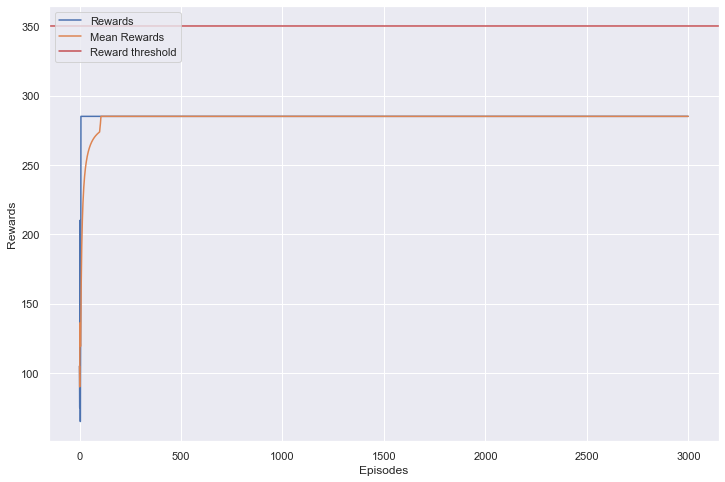

In [49]:
plot_rewards(agentPGR)

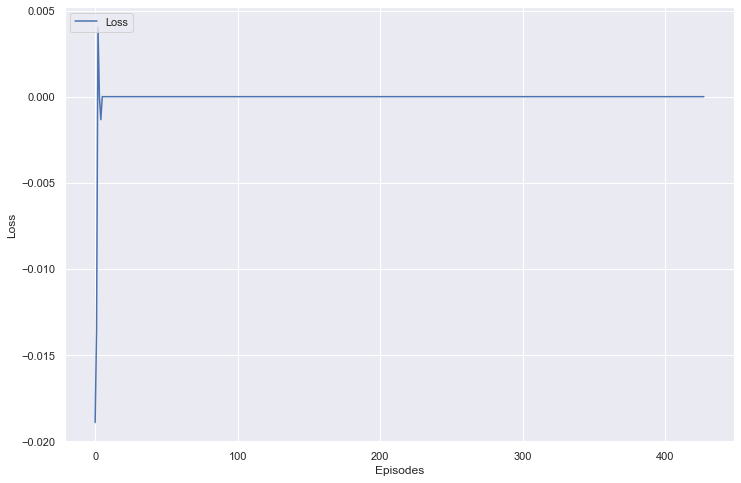

In [50]:
plot_loss(agentPGR)

In [51]:
print("La mitjana global de les recompenses és de: {} ".format(np.mean(agentPGR.mean_training_rewards)))

La mitjana global de les recompenses és de: 283.6265889864407 


La mitjana no és gens despreciable però el que no m'agrada és l'estancament en les recompenses ja que l'agent sembla que s'estanca en un espai "limitat". 

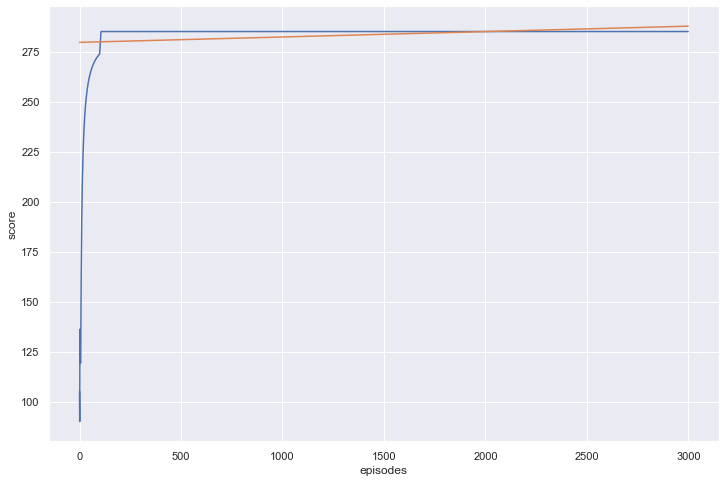

In [52]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set()

scores = agentPGR.mean_training_rewards
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

Podem veure que la tendència de les recompenses no és bona i, encara que parteix d'un valor alt, en les diferents iteracions quasi no millora.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.5 Anàlisi (0.2 ptos):</strong> Guardar el model entrenat en format “.pth” i comentar els resultats obtinguts. Què ha passat amb aquest model?
</div>

In [53]:
torch.save(agentPGR.dnnetwork.state_dict(), 'reinforceAgent_Trained_Model_PGReinforce.pth')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
El comportament en aquest cas és força estany ja que el model comença a aprendre de forma progressiva fins que arriba un punt que s'estanca i sempre obtenim el mateix reward. Això pot ser degut a que tinguem una manca de variança en la recompensa i l'agent no cerqui altre possibles accions. És a dir, tenim una politica óptima a escala local i ja no explorem més l'entorn.  Una altre possible solució seria fer servir actor-crític que fa servir la idea de les Dueling amb dues xarxes neuronals, una per a la política i una per a la funció de valor ens permet obtenir un algorisme capaç de seleccionar la millor acció en cada estat.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.6 Exercici (0.15 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calculeu la suma de recompenses per cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn. Comentar-ne els resultats.
<p>Emmagatzema una partida d'exemple de l'agent a la carpeta de vídeos en format GIF per poder visualitzar el seu comportament i comenta'l.</p>
</div>

Episode 19/20.

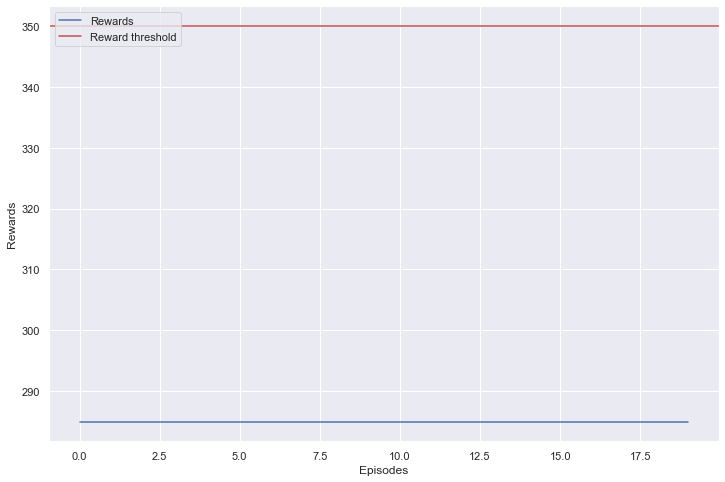

In [54]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()        
        action_space = np.arange(env.action_space.n)
        observation = env.reset()
        start_game = preprocess_observation(observation)
        state= stack_frame(None, start_game, True)
        total_reward = 0
        done = False
    
        while not done:
            action_probs = ag.dnnetwork.get_action_prob(state).detach().numpy()                                             
            action_probs = np.squeeze(action_probs)                    
            action = np.random.choice(action_space, p=action_probs)            
            observation, reward, done, info = env.step(action)
            total_reward += reward
            state= stack_frame(state, preprocess_observation(observation), False)
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

total_reward_list = play_games(env, agentPGR, 20)
plot_rewards_min(agentPGR, total_reward_list)

In [55]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# Funció per a jugar i enmagatzemar una partida en format GIF amb un agent entrenat
def save_agentpgr_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :param nombre_fichero:  nom del fitxer
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    action_space = np.arange(env.action_space.n)
    incio_juego = preprocess_observation(observation)
    state= stack_frame(None, incio_juego, True)
    total_reward = 0 
    t=0
    while True:
            state= stack_frame(state, preprocess_observation(observation), False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))                            
            action_probs = ag.dnnetwork.get_action_prob(state).detach().numpy()                                                         
            action_probs = np.squeeze(action_probs)                    
            action = np.random.choice(action_space, p=action_probs)
            observation, reward, done, info = env.step(action)            
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)


# Juguem i enmagatzemem una partida amb l'agent entrenat 
save_agentpgr_gif(env, agentPGR, 'space_invader_PGRAgent_comportamiento.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>  

![title](videos/space_invader_PGRAgent_comportamiento.gif)  
<br>

L'exemple és molt similar al del exercici 1. L'agent no es mou de la seva possició i es queda disparant fins que el maten. No realitza cap altre possible acció ja que no explora l'entorn. En aquesta posició és capaç en les diferens "vides" de la partida obtenir una puntuació prou bona però en cap cas sembla un comportamnet molt inteligent. El que si sembla és més efectiu que l'exercici 1 encara que no és mogui del lloc.
<br><br>
</div>

## 5. Comparació de models (1 pt)
<p></p>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>5.1 Exercici (0.5 pts):</strong> Mostra en un mateix gràfic l'evolució de la mitjana de recompenses dels tres models juntament amb el llindar de recompensa.
</div>

In [56]:
 def plot_comparing_rewards(agentDQN, agentDDQN, agentPGR):
        plt.figure(figsize=(12,8))
        plt.plot(agentDQN.mean_training_rewards, color='y', label='DQN Mean Rewards')
        plt.plot(agentDDQN.mean_training_rewards, color='g', label='DDQN Mean Rewards')
        plt.plot(agentPGR.mean_training_rewards, color='b', label="PGR Mean Rewards")
        plt.axhline(agentPGR.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()    

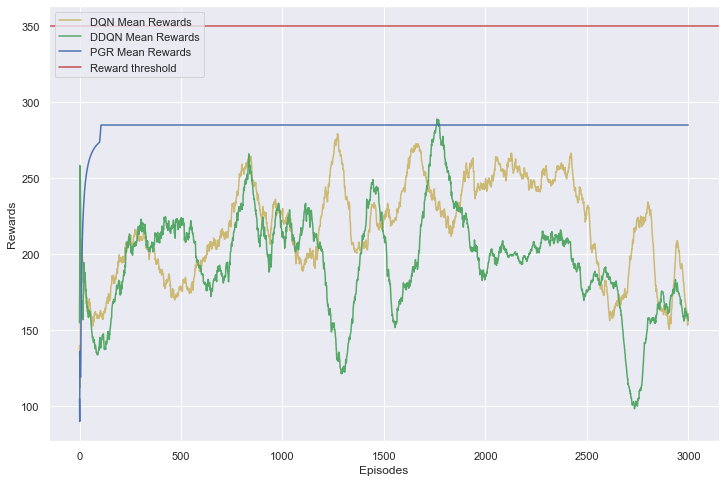

In [57]:
plot_comparing_rewards(agentDQN, agentDDQN, agentPGR)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>5.2 Anàlisi (0.5 pts):</strong> Analitzar els resultats obtinguts tenint en compte el nombre depisodis, el temps dentrenament i el rendiment dels tres agents entrenats observat en apartats anteriors. Quin agent presenta un comportament millor? Per què?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br><br>

- DQN té un compotament molt erràtic i poc equilibrat on en l'aprenentatge no veiem una tendència de millora. Els valors van fluctuant de forma molt aleatoria amb valors al voltant de 250 però altres molt baixo. No s'observa un patró de millora. 

    
- DDQN té un comportament molt millor. Encara que fluctua també, si que s'aprecia una tendència de pujada. Al final del procés podem veure que la majoria de les partides estan per sobre dels 200 punts amb algunes partides de més de 300 punts. En el gif podem veure que l'agent fa moure la nau per a millorar la partida.

    
- PGR té un creixement molt ràpid però arriba un punt que s'estanca. Sembla com que deixa d'explorar l'entorn i sempre obtenim la mateixa recompensa. Els estats están molt correlacionats i al no poder fer servir un buffer per a triar accions aleatories no relacionades anem a parar a un subconjunt petit del entorn.
    
    
Dueling DQN és el que te millor comportament ja que aprén durant tot el procés de forma incremental. Segurament modificant algún hiperparàmetre com per exemple DNN_UPD (Freqüència d'actualització de la xarxa neuronal) a un valor més baix podrem obtenir encara millors valors. 
</div>

## 6. Optimizació (1 pto)

En aquest apartat volem trobar la millor arquitectura i hiperparàmetres per optimitzar la precisió del model. Els punts que volem tenir en compte per a la cerca del millor model són els següents:
<ul>
     <li>Nombre d'unitats de les capes</li>
     <li>Learning rate</li>
     <li>Actualització de la xarxa principal</li>
     <li>Sincronització de la xarxa objectiu</li>
     <li>Batch size</li>
     <li>Gamma</li>
     <li>Nombre de partides de l'entrenament</li>
<ul>

Podeu modificar o adaptar la configuració com considereu oportú sempre que justifiqueu el benefici i el canvi.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>6.1 Exercici (1 pt):</strong> Triar un dels dos models de DQN implementats (DQN o dueling DQN) i experimentar amb diferents combinacions de valors per als paràmetres especificats. L'objectiu és aconseguir un model amb millors resultats que el presentat a la PAC. <b>Indicar</b> les proves realitzades, però presentar <b>únicament</b> l'execució i els resultats de la millor opció. Justificar els valors escollits d'hiperparàmetres per a les diferents proves realitzades i comentar els resultats d'entrenament i rendiment de l'agent entrenat.
</div>

In [58]:
lr = 0.001          #Velocitat d'aprenentatge
BATCH_SIZE = 32     #Conjunt a agafar del buffer per a la xarxa neuronal 
MEMORY_SIZE = 100000 # (8000) Màxima capacitat del buffer
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
EPSILON = 1         #Valor inicial d'epsilon
EPSILON_DECAY = .995 #Decaïment d'epsilon
EPSILON_MIN = 0.01  #Valor mínim d'epsilon
BURN_IN = 100       #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 1000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250  #Nombre mínim d'episodis
DNN_UPD = 2         # (100) Freqüència d'actualització de la xarxa neuronal 
DNN_SYNC = 10000    # (5000) Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 350 #Llindar de recompensa on es considera que s'ha assolit el problema

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
ddqn2 = DuelingDQN(env, learning_rate=lr)
agentDDQN2 = DuelingDQNAgent(env, ddqn2, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
agentDDQN2.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)


Filling replay buffer...
Training...
Episode 1000 Mean Rewards 294.60 Epsilon 0.01 Time 789.85 minutes Remaining Time 0.0 minutes			 64.24 minutes			
Episode limit reached.


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br><br>
En aquest exemple el que hem fet és baixar el valor de DNN_UPD de 100 a 2. Com ja he comentat previament un valor molt alt fa que el model no convergeixi de forma correcta i un valor molt baix fa que el temps en l'aprenentatge sigui molt alt. El que es recomana és un valor entre 1 i 3 i per probar que és correcte aquesta afirmació hem iterat en 1000 iteracions.


</div>

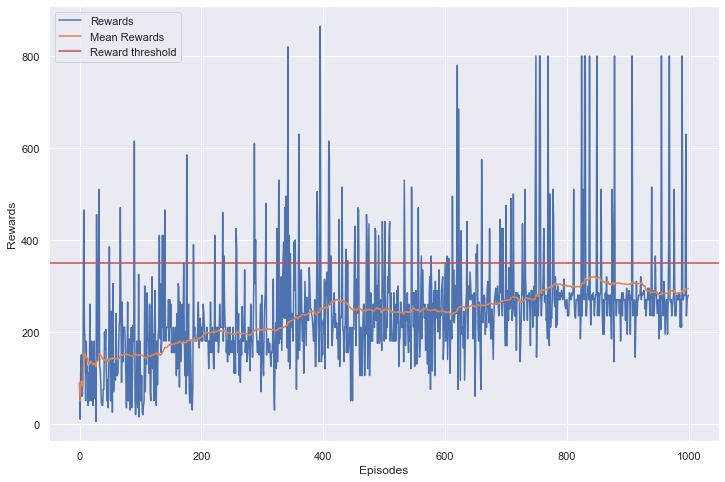

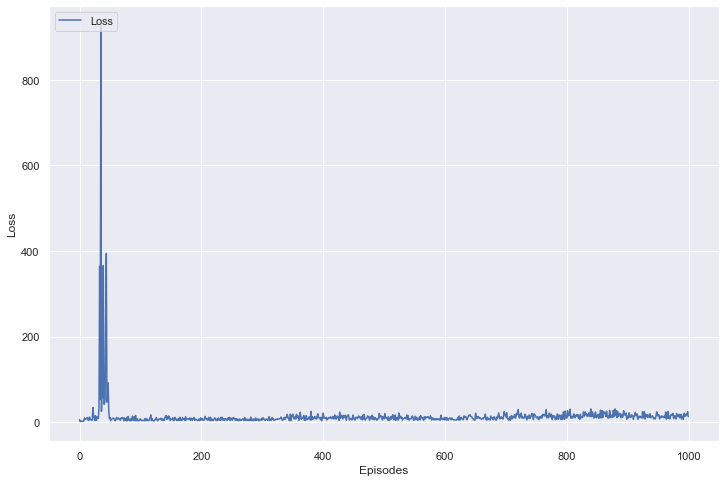

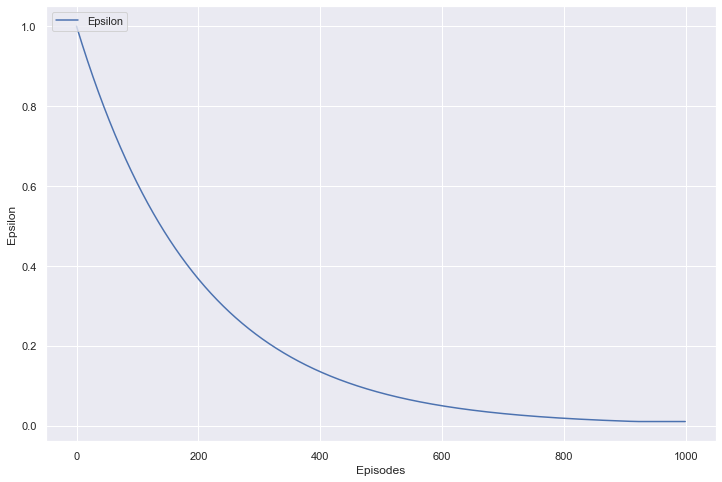

In [59]:
plot_rewards(agentDDQN2)
plot_loss(agentDDQN2)
plot_epsilon(agentDDQN2)

def plot_comparing_rewards(agentDQN, agentDDQN, agentPGR, agentDDQN2):
        plt.figure(figsize=(12,8))
        plt.plot(agentDQN.mean_training_rewards, color='y', label='DQN Mean Rewards')
        plt.plot(agentDDQN.mean_training_rewards, color='g', label='DDQN Mean Rewards')
        plt.plot(agentPGR.mean_training_rewards, color='b', label="PGR Mean Rewards")
        plt.plot(agentDDQN2.mean_training_rewards, color='b', label="DDQN Improved Mean Rewards")
        plt.axhline(agentPGR.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()    

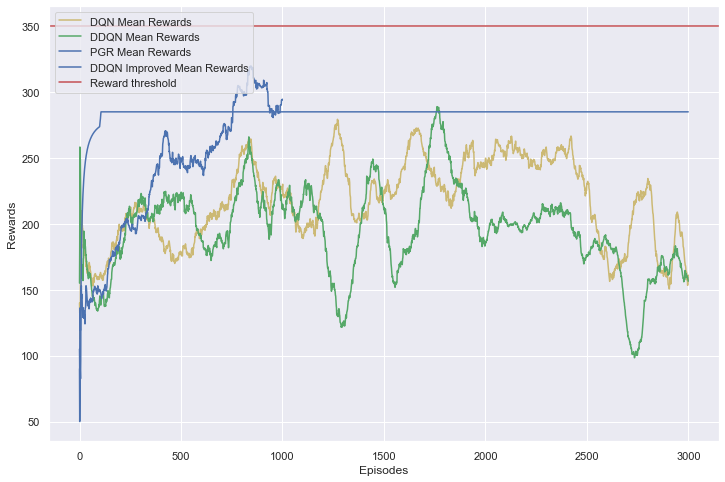

In [60]:
plot_comparing_rewards(agentDQN, agentDDQN, agentPGR, agentDDQN2)

In [61]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# Juguem i enmagatzemem una partida amb l'agent entrenat 
save_agent_gif(env, agentDDQN, 'space_invader_duelingDQNAgent_comportamientov2.gif')

Podem veure que aquest canvi ha beneficiat a l'aprenentatge ja que els reward van augmentant de forma progressiva en les diferents iteracions. 

Farem l'experiment altre cop però amb 3000 iteracions.

In [ ]:
lr = 0.001          #Velocitat d'aprenentatge
BATCH_SIZE = 32     #Conjunt a agafar del buffer per a la xarxa neuronal 
MEMORY_SIZE = 100000 # (8000) Màxima capacitat del buffer
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
EPSILON = 1         #Valor inicial d'epsilon
EPSILON_DECAY = .995 #Decaïment d'epsilon
EPSILON_MIN = 0.01  #Valor mínim d'epsilon
BURN_IN = 100       #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 5000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250  #Nombre mínim d'episodis
DNN_UPD = 2         # (100) Freqüència d'actualització de la xarxa neuronal 
DNN_SYNC = 5000    # (5000) Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 350 #Llindar de recompensa on es considera que s'ha assolit el problema

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
ddqn2 = DuelingDQN(env, learning_rate=lr)
agentDDQN2 = DuelingDQNAgent(env, ddqn2, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
agentDDQN2.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)


Filling replay buffer...
Training...
Episode 2595 Mean Rewards 268.60 Epsilon 0.01 Time 2074.05 minutes Remaining Time 1922.19 minutes		0.71 minutes		

In [ ]:
plot_comparing_rewards(agentDQN, agentDDQN, agentPGR, agentDDQN2)

Queda molt evident que el millor model és el que hem optimitzat. El Dueling DQN però amb un valor d'acutalització de xarxa neuronal molt més baix.

In [ ]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set()

scores = agentDDQN2.mean_training_rewards
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

El creiement dels reward és pot comprovar que te una tendència molt bona i és molt probable que amb més iteracions haguéssim aconseguit el llindar del 350. Per temas de temps i rendiment no ho hem provat. Amb l'exemple anterior he estat vora de 2619 minuts, és a dir, més d'un dia executant el procés.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
 
![title](videos/space_invader_duelingDQNAgent_comportamientov3.gif)  
    
<br><br>
Com ja he comentat previament al baixar el valor de DNN_UPD de 100 a 2 fa que el model convergeixi de forma correcta encara que tinguem un temps d'aprenentatge molt més alt. 
<br><br>
En el plot de la comparativa dels mean-rewards la gràfica té la millor tendencia de creixement. El gif també mostra que l'agent realitza moviments amb coherencia per tal de fer durar la partida i guanyar més punts.
</div>

In [ ]:
lr = 0.001          #Velocitat d'aprenentatge
BATCH_SIZE = 32     #Conjunt a agafar del buffer per a la xarxa neuronal 
MEMORY_SIZE = 100000 # (8000) Màxima capacitat del buffer
GAMMA = 0.99        #Valor gamma de l'equació de Bellman
EPSILON = 1         #Valor inicial d'epsilon
EPSILON_DECAY = .995 #Decaïment d'epsilon
EPSILON_MIN = 0.01  #Valor mínim d'epsilon
BURN_IN = 100       #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 5000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250  #Nombre mínim d'episodis
DNN_UPD = 2         # (100) Freqüència d'actualització de la xarxa neuronal 
DNN_SYNC = 5000    # (5000) Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 350 #Llindar de recompensa on es considera que s'ha assolit el problema

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
ddqn2 = DuelingDQN(env, learning_rate=lr)
agentDDQN2 = DuelingDQNAgent(env, ddqn2, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
agentDDQN2.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)
